In [1]:
import pymc as pm
import numpy as np
from matplotlib import pyplot as plt

from discretize import TensorMesh
from SimPEG import simulation, maps

import pymc as pm

import scipy.sparse as sp

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.0.0b1


(-2.0, 2.0)

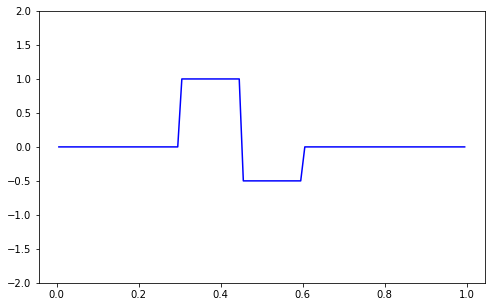

In [2]:
nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

# Mapping from the model space to the row space of the linear operator
# model_map = maps.IdentityMap(mesh)

# Plotting the true model
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
ax.plot(mesh.vectorCCx, true_model, "b-")
ax.set_ylim([-2, 2])

Text(0.5, 1.0, 'Columns of matrix G')

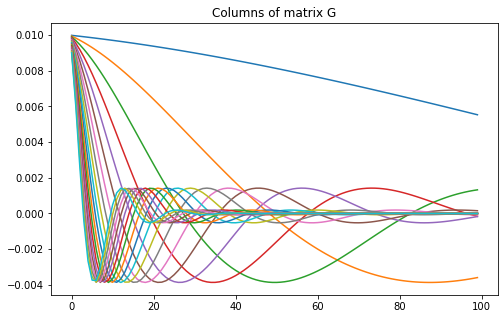

In [3]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial. The columns of the linear operator
# represents a set of decaying and oscillating functions.
j0 = 1
jn = 60
p = -0.25
q = 0.25

sim = simulation.ExponentialSinusoidSimulation(model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=p, q=q, j0=j0, jn=jn)
G = sim.G

# Plot the columns of G
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
for i in range(G.shape[0]):
    ax.plot(G[i, :])

ax.set_title("Columns of matrix G")

In [4]:
# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

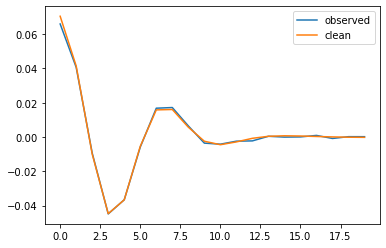

In [5]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend()

In [7]:
D_matrix = sp.diags([-1, 1], [-1, 0], shape=(nParam+1, nParam)).toarray()
Tau = D_matrix.T @ D_matrix

In [8]:
diff_std = 0.07

m_max_post = np.linalg.solve(1/data_std**2 * G.T @ G + 1/diff_std**2 * Tau, 1/data_std**2 * G.T @ data_obj.dobs)

del_d = G @ m_max_post - data_obj.dobs
print(1/data_std**2 * del_d.T @ del_d)

19.360611229048786


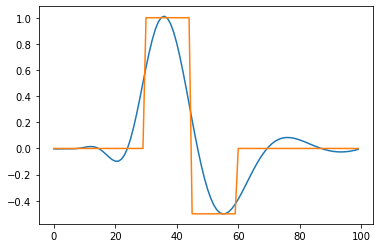

In [9]:
plt.plot(m_max_post)
plt.plot(true_model)

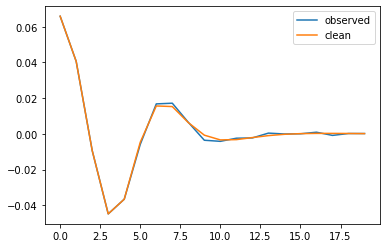

In [10]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='clean')
plt.legend()

In [11]:
model_prior_stds = np.array([0.1, 0.1, 0.1])
model_prior_means = np.array([0, 1.0, -0.5])
model_prior_weights = np.array([0.5, 0.25, 0.25])
model_prior_std = 0.5

with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    #sigma = HalfCauchy("sigma", beta=10)
    #model_prior = Normal("Model Prior", mu=0, sigma=model_prior_std, shape=nParam)
    model_prior = pm.MvNormal("Model Prior", mu=np.zeros(nParam), tau=1/diff_std**2 * Tau, shape=nParam)
    #model_prior = Laplace("Model Prior", mu=0, b=1.0, shape=nParam)

    # Define likelihood
    likelihood = pm.Normal("y", mu=G @ model_prior, sigma=data_std, observed=data_obj.dobs)

    # Inference!
    # draw 8000 posterior samples using NUTS sampling
    idata = pm.sample(8000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/josephcapriotti/opt/anaconda3/envs/mcmc_tutorial/lib/python3.8/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Model Prior]
/Users/josephcapriotti/opt/anaconda3/envs/mcmc_tutorial/lib/python3.8/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 115 seconds.


In [12]:
draws = idata.posterior['Model Prior']

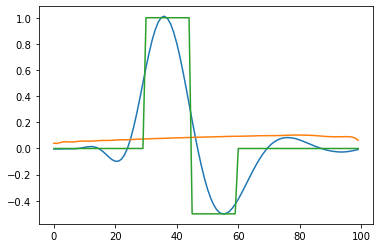

In [13]:
plt.plot(draws.mean(axis=(0, 1)))
plt.plot(draws.std(axis=(0, 1)))
plt.plot(true_model)

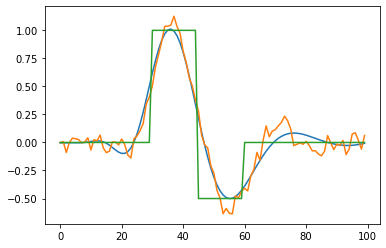

In [14]:
plt.plot(draws.mean(axis=(0, 1)))
plt.plot(draws[3, 6890])
plt.plot(true_model)

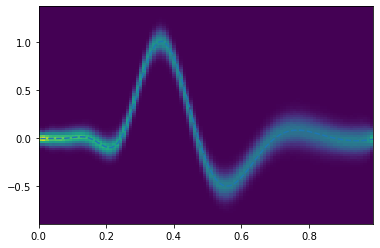

In [15]:
plt.hist2d(np.tile(np.arange(100)/100, 4*8000), np.array(draws).reshape(-1),bins=100);
plt.plot(mesh.vectorCCx, draws.mean(axis=(0, 1)), '--',label='MCMC mean')